# 1-4,时间序列数据建模流程范例

国内的新冠肺炎疫情从发现至今已经持续3个多月了，这场起源于吃野味的灾难给大家的生活造成了诸多方面的影响。

有的同学是收入上的，有的同学是感情上的，有的同学是心理上的，还有的同学是体重上的。

那么国内的新冠肺炎疫情何时结束呢？什么时候我们才可以重获自由呢？

本篇文章将利用TensorFlow2.0建立时间序列RNN模型，对国内的新冠肺炎疫情结束时间进行预测。

![](./data/疫情前后对比.png)

### 一，准备数据



本文的数据集取自tushare，获取该数据集的方法参考了以下文章。

《https://zhuanlan.zhihu.com/p/109556102》

![](./data/1-4-新增人数.png)


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks 


(array([ 0., 10., 20., 30., 40., 50.]), <a list of 6 Text xticklabel objects>)

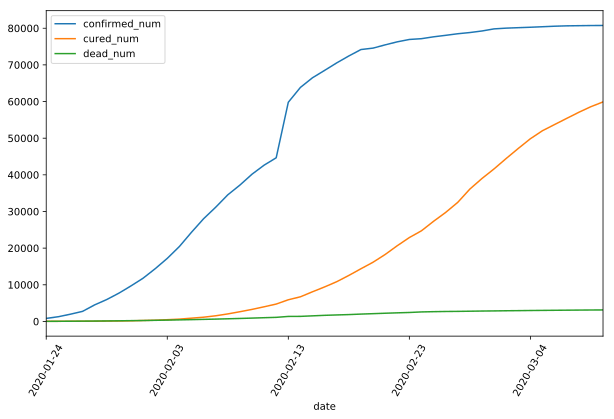

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)


![](./data/1-4-累积曲线.png)

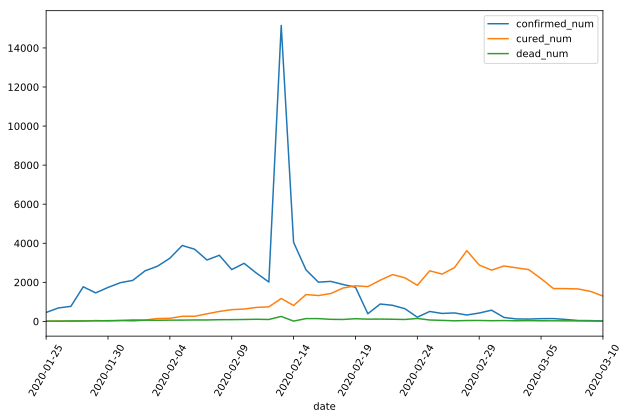

In [3]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")


![](./data/1-4-新增曲线.png)

In [4]:
#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()



### 二，定义模型

使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用函数式API构建任意结构模型。

In [5]:
#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config


In [6]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

```
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0         
=================================================================
Total params: 348
Trainable params: 348
Non-trainable params: 0
_________________________________________________________________
```

### 三，训练模型

训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。

In [7]:
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config


In [12]:
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 500)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=1000,callbacks = callbacks_list)


Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 0.1811
Epoch 2/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.1813
Epoch 3/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.1815
Epoch 4/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1812
Epoch 5/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.1811
Epoch 6/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.1813
Epoch 7/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.1812
Epoch 8/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.1811
Epoch 9/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.1811
Epoch 10/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.1812
Epoch 11/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.1811
Epoch 12/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.1811
Epoch 13/1000
1/1 [====================

Epoch 103/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.1809
Epoch 104/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.1809
Epoch 105/1000
1/1 [==============================] - 0s 81ms/step - loss: 0.1809
Epoch 106/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.1809
Epoch 107/1000
1/1 [==============================] - 0s 98ms/step - loss: 0.1809
Epoch 108/1000
1/1 [==============================] - 0s 103ms/step - loss: 0.1809
Epoch 109/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.1809
Epoch 110/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.1809
Epoch 111/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.1809
Epoch 112/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.1809
Epoch 113/1000
1/1 [==============================] - 0s 87ms/step - loss: 0.1809
Epoch 114/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.1809
Epoch 115/1000


Epoch 203/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.1807
Epoch 204/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.1807
Epoch 205/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.1807
Epoch 206/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.1807
Epoch 207/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.1807
Epoch 208/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1807
Epoch 209/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.1807
Epoch 210/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.1807
Epoch 211/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1807
Epoch 212/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.1807
Epoch 213/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.1807
Epoch 214/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.1806
Epoch 215/1000
1

Epoch 303/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.1804
Epoch 304/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.1804
Epoch 305/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.1804
Epoch 306/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.1804
Epoch 307/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1804
Epoch 308/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.1804
Epoch 309/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.1804
Epoch 310/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.1804
Epoch 311/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.1804
Epoch 312/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.1804
Epoch 313/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.1804
Epoch 314/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.1804
Epoch 315/1000
1

Epoch 403/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1802
Epoch 404/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1802
Epoch 405/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.1801
Epoch 406/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.1802
Epoch 407/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.1801
Epoch 408/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.1801
Epoch 409/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.1801
Epoch 410/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.1801
Epoch 411/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.1801
Epoch 412/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.1801
Epoch 413/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.1801
Epoch 414/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.1801
Epoch 415/1000
1

Epoch 503/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.1798
Epoch 504/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1798
Epoch 505/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.1798
Epoch 506/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.1798
Epoch 507/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.1798
Epoch 508/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1798
Epoch 509/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1798
Epoch 510/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.1798
Epoch 511/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1798
Epoch 512/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1798
Epoch 513/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.1798
Epoch 514/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.1798
Epoch 515/1000
1

Epoch 603/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.1795
Epoch 604/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.1795
Epoch 605/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1795
Epoch 606/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.1795
Epoch 607/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.1795
Epoch 608/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.1795
Epoch 609/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.1795
Epoch 610/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1795
Epoch 611/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.1795
Epoch 612/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.1795
Epoch 613/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.1795
Epoch 614/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.1795
Epoch 615/1000
1

Epoch 703/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.1793
Epoch 704/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.1793
Epoch 705/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.1793
Epoch 706/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.1793
Epoch 707/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.1793
Epoch 708/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.1792
Epoch 709/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.1792
Epoch 710/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.1792
Epoch 711/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.1792
Epoch 712/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.1792
Epoch 713/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.1792
Epoch 714/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1792
Epoch 715/1000
1

Epoch 803/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.1791
Epoch 804/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.1791
Epoch 805/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.1791
Epoch 806/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.1791
Epoch 807/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.1791
Epoch 808/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1791
Epoch 809/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1791
Epoch 810/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.1791
Epoch 811/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1791
Epoch 812/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1791
Epoch 813/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.1791
Epoch 814/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1791
Epoch 815/1000
1

Epoch 903/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.1790
Epoch 904/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.1790
Epoch 905/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1790
Epoch 906/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.1790
Epoch 907/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.1790
Epoch 908/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.1790
Epoch 909/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.1790
Epoch 910/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.1790
Epoch 911/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.1790
Epoch 912/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.1790
Epoch 913/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.1790
Epoch 914/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.1790
Epoch 915/1000
1

```
Epoch 371/500
1/1 [==============================] - 0s 61ms/step - loss: 0.1184
Epoch 372/500
1/1 [==============================] - 0s 64ms/step - loss: 0.1177
Epoch 373/500
1/1 [==============================] - 0s 56ms/step - loss: 0.1169
Epoch 374/500
1/1 [==============================] - 0s 50ms/step - loss: 0.1161
Epoch 375/500
1/1 [==============================] - 0s 55ms/step - loss: 0.1154
Epoch 376/500
1/1 [==============================] - 0s 55ms/step - loss: 0.1147
Epoch 377/500
1/1 [==============================] - 0s 62ms/step - loss: 0.1140
Epoch 378/500
1/1 [==============================] - 0s 93ms/step - loss: 0.1133
Epoch 379/500
1/1 [==============================] - 0s 85ms/step - loss: 0.1126
Epoch 380/500
1/1 [==============================] - 0s 68ms/step - loss: 0.1119
Epoch 381/500
1/1 [==============================] - 0s 52ms/step - loss: 0.1113
Epoch 382/500
1/1 [==============================] - 0s 54ms/step - loss: 0.1107
Epoch 383/500
1/1 [==============================] - 0s 55ms/step - loss: 0.1100
Epoch 384/500
1/1 [==============================] - 0s 56ms/step - loss: 0.1094
Epoch 385/500
1/1 [==============================] - 0s 54ms/step - loss: 0.1088
Epoch 386/500
1/1 [==============================] - 0s 74ms/step - loss: 0.1082
Epoch 387/500
1/1 [==============================] - 0s 60ms/step - loss: 0.1077
Epoch 388/500
1/1 [==============================] - 0s 52ms/step - loss: 0.1071
Epoch 389/500
1/1 [==============================] - 0s 52ms/step - loss: 0.1066
Epoch 390/500
1/1 [==============================] - 0s 56ms/step - loss: 0.1060
Epoch 391/500
1/1 [==============================] - 0s 61ms/step - loss: 0.1055
Epoch 392/500
1/1 [==============================] - 0s 60ms/step - loss: 0.1050
Epoch 393/500
1/1 [==============================] - 0s 59ms/step - loss: 0.1045
Epoch 394/500
1/1 [==============================] - 0s 65ms/step - loss: 0.1040
Epoch 395/500
1/1 [==============================] - 0s 58ms/step - loss: 0.1035
Epoch 396/500
1/1 [==============================] - 0s 52ms/step - loss: 0.1031
Epoch 397/500
1/1 [==============================] - 0s 58ms/step - loss: 0.1026
Epoch 398/500
1/1 [==============================] - 0s 60ms/step - loss: 0.1022
Epoch 399/500
1/1 [==============================] - 0s 57ms/step - loss: 0.1017
Epoch 400/500
1/1 [==============================] - 0s 63ms/step - loss: 0.1013
Epoch 401/500
1/1 [==============================] - 0s 59ms/step - loss: 0.1009
Epoch 402/500
1/1 [==============================] - 0s 53ms/step - loss: 0.1005
Epoch 403/500
1/1 [==============================] - 0s 56ms/step - loss: 0.1001
Epoch 404/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0997
Epoch 405/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0993
Epoch 406/500
1/1 [==============================] - 0s 53ms/step - loss: 0.0990
Epoch 407/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0986
Epoch 408/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0982
Epoch 409/500
1/1 [==============================] - 0s 67ms/step - loss: 0.0979
Epoch 410/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0976
Epoch 411/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0972
Epoch 412/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0969
Epoch 413/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0966
Epoch 414/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0963
Epoch 415/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0960
Epoch 416/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0957
Epoch 417/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0954
Epoch 418/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0951
Epoch 419/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0948
Epoch 420/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0946
Epoch 421/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0943
Epoch 422/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0941
Epoch 423/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0938
Epoch 424/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0936
Epoch 425/500
1/1 [==============================] - 0s 100ms/step - loss: 0.0933
Epoch 426/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0931
Epoch 427/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0929
Epoch 428/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0926
Epoch 429/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0924
Epoch 430/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0922
Epoch 431/500
1/1 [==============================] - 0s 75ms/step - loss: 0.0920
Epoch 432/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0918
Epoch 433/500
1/1 [==============================] - 0s 77ms/step - loss: 0.0916
Epoch 434/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0914
Epoch 435/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0912
Epoch 436/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0911
Epoch 437/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0909
Epoch 438/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0907
Epoch 439/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0905
Epoch 440/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0904
Epoch 441/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0902
Epoch 442/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0901
Epoch 443/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0899
Epoch 444/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0898
Epoch 445/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0896
Epoch 446/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0895
Epoch 447/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0893
Epoch 448/500
1/1 [==============================] - 0s 64ms/step - loss: 0.0892
Epoch 449/500
1/1 [==============================] - 0s 70ms/step - loss: 0.0891
Epoch 450/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0889
Epoch 451/500
1/1 [==============================] - 0s 53ms/step - loss: 0.0888
Epoch 452/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0887
Epoch 453/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0886
Epoch 454/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0885
Epoch 455/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0883
Epoch 456/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0882
Epoch 457/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0881
Epoch 458/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0880
Epoch 459/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0879
Epoch 460/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0878
Epoch 461/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0878
Epoch 462/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0879
Epoch 463/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0879
Epoch 464/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0888
Epoch 465/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0875
Epoch 466/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0873
Epoch 467/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0872
Epoch 468/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0872
Epoch 469/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0871
Epoch 470/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0871
Epoch 471/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0870
Epoch 472/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0871
Epoch 473/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0869
Epoch 474/500
1/1 [==============================] - 0s 61ms/step - loss: 0.0870
Epoch 475/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0868
Epoch 476/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0868
Epoch 477/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0866
Epoch 478/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0867
Epoch 479/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0865
Epoch 480/500
1/1 [==============================] - 0s 65ms/step - loss: 0.0866
Epoch 481/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0864
Epoch 482/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0865
Epoch 483/500
1/1 [==============================] - 0s 53ms/step - loss: 0.0863
Epoch 484/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0864
Epoch 485/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0862
Epoch 486/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0863
Epoch 487/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0861
Epoch 488/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0862
Epoch 489/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0860
Epoch 490/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0861
Epoch 491/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0859
Epoch 492/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0860
Epoch 493/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0859
Epoch 494/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0860
Epoch 495/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0858
Epoch 496/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0859
Epoch 497/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0857
Epoch 498/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0858
Epoch 499/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0857
Epoch 500/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0858
```

### 四，评估模型

评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()


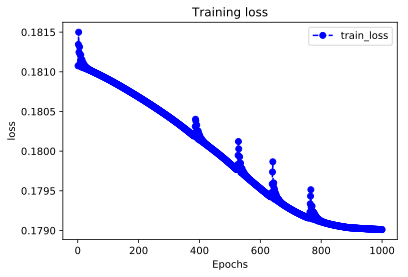

In [14]:
plot_metric(history,"loss")

![](./data/1-4-损失函数曲线.png)

### 五，使用模型

此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

In [20]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


![](./data/1-4-日期3月10.png)

In [21]:
#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(200):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [22]:
dfresult.query("confirmed_num==0").head()

# 第55天开始新增确诊降为0，第45天对应3月10日，也就是10天后，即预计3月20日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
49,0.0,838.0,211.0
50,0.0,869.0,267.0
51,0.0,948.0,263.0
52,0.0,1058.0,224.0
53,0.0,1192.0,176.0


![](./data/1-4-预测确诊.png)

In [23]:
dfresult.query("cured_num==0").head()

# 第164天开始新增治愈降为0，第45天对应3月10日，也就是大概4个月后，即7月10日左右全部治愈。
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数。

,confirmed_num,cured_num,dead_num
152,0.0,0.0,0.0
153,0.0,0.0,0.0
154,0.0,0.0,0.0
155,0.0,0.0,0.0
156,0.0,0.0,0.0


![](./data/1-4-预测治愈.png)

In [24]:
dfresult.query("dead_num==0").head()

# 第60天开始，新增死亡降为0，第45天对应3月10日，也就是大概15天后，即20200325
# 该预测较为合理

,confirmed_num,cured_num,dead_num
56,0.0,1785.0,0.0
57,0.0,2651.0,0.0
58,0.0,3938.0,0.0
59,0.0,4043.0,0.0
60,0.0,3748.0,0.0


![](./data/1-4-预测死亡.png)

### 六，保存模型

推荐使用TensorFlow原生方式保存模型。

In [25]:
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets
export saved model.


In [26]:
model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

array([[1.2413469e+03, 9.3873260e+01, 2.3057466e+00],
       [1.5311326e+03, 7.3605171e+01, 4.6883516e+00],
       [1.6707028e+03, 1.5681102e+02, 4.3809185e+00],
       [1.9119935e+03, 1.6747842e+02, 4.9189262e+00],
       [2.2981772e+03, 2.7735281e+02, 4.9957843e+00],
       [2.1846287e+03, 2.7841956e+02, 5.6106501e+00],
       [1.8587677e+03, 4.1282898e+02, 5.6106501e+00],
       [2.0018862e+03, 5.4403821e+02, 6.6098070e+00],
       [1.5683906e+03, 6.3897821e+02, 6.8403816e+00],
       [1.7582299e+03, 6.7418066e+02, 7.4552474e+00],
       [1.4589818e+03, 7.6272021e+02, 8.3006878e+00],
       [1.1916694e+03, 7.9365576e+02, 7.4552474e+00],
       [8.9602891e+03, 1.2491544e+03, 1.9521988e+01],
       [2.3933926e+03, 8.6619415e+02, 9.9915689e-01],
       [2.0298534e+03, 1.3226505e+03, 1.3994012e+02],
       [2.1502483e+03, 1.3570670e+03, 1.1055710e+02],
       [1.9267231e+03, 1.4293669e+03, 1.0020187e+02],
       [1.7387355e+03, 1.6714281e+03, 1.2851907e+02],
       [3.9147519e+02, 1.731

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"Python与算法之美"下留言。作者时间和精力有限，会酌情予以回复。

![image.png](./data/Python与算法之美logo.jpg)